In [2]:
pip install sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.7 MB/s eta 0:00:00


In [10]:
pip install deep-translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.5 MB/s eta 0:00:00


# Preprocessing

In [11]:
import pandas as pd
import re
import nltk
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from textblob import TextBlob
from deep_translator import GoogleTranslator
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.over_sampling import SMOTE


In [12]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
df = pd.read_csv('raw_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2514 entries, 0 to 2513
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   conversation_id_str      2514 non-null   object 
 1   created_at               2513 non-null   object 
 2   favorite_count           2512 non-null   float64
 3   full_text                2513 non-null   object 
 4   id_str                   2512 non-null   object 
 5   image_url                780 non-null    object 
 6   in_reply_to_screen_name  655 non-null    object 
 7   lang                     2512 non-null   object 
 8   location                 1934 non-null   object 
 9   quote_count              2512 non-null   object 
 10  reply_count              2512 non-null   float64
 11  retweet_count            2512 non-null   object 
 12  tweet_url                2511 non-null   object 
 13  user_id_str              2511 non-null   float64
 14  username                

In [23]:
df = df[['full_text']]
df = df.dropna()
df.sample(n=5)

,full_text
336,Manfaatkan AI untuk tingkatkan kesejahteraan m...
738,Kaum perempuan mampu menghadirkan perspektif ...
282,Malaysia manfaat AI kenal pasti transaksi wang...
2411,Manfaatkan AI untuk tingkatkan kesejahteraan m...
1659,Teman-teman tech di @KawalPemilu_org &amp; fri...


In [25]:
df.isnull().sum()

,0
full_text,0


Preprocessing (Stemmer Sastrawi)

In [ ]:
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.tokenize import word_tokenize


stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()
stopword_factory = StopWordRemoverFactory()
stopword_remover = stopword_factory.create_stop_word_remover()
stopword_list = stopword_factory.get_stop_words()
def clean_text(text):
    if not isinstance(text, str):
        return ""

    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)   # Menghapus URL
    text = re.sub(r'@\w+', '', text) # Menghapus mention (@username)
    text = re.sub(r'#\w+', '', text) # Menghapus hashtag (#hashtag)
    text = re.sub(r'\d+', '', text) # Menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # Menghapus tanda baca kecuali spasi
    text = text.lower() # Mengubah teks menjadi lowercase
    words = word_tokenize(text)  # Tokenisasi
    words = [word for word in words if word not in stopword_list]  # Hapus stopword berbasis token dari stopword list
    words = [stemmer.stem(word) for word in words]  # Stemming

    return ' '.join(words)

df['tweet_clean'] = df['full_text'].apply(clean_text)
df = df.drop_duplicates()


In [27]:
df.head()

,full_text,tweet_clean
0,Maybe read this ss again. Penggunaan AI itu ha...,maybe read this ss again guna ai harmful bange...
1,Kata Dharma AI itu artificial intelligence. Da...,kata dharma ai artificial intelligence kata in...
2,Melihat teman-teman di sekitar terlalu bergant...,lihat temanteman terlalu gantung aplikasi bena...
3,ㅤ Yang paling kena dampaknya mungkin di sektor...,paling kena dampak mungkin sektor kayak l...
4,Bayangin urusan riil problema AI: - pengembang...,bayangin urus riil problema ai kembang etis cu...


Translating Data

In [34]:
def translate_text(text):
    if not isinstance(text, str) or text.strip() == "":
        return "TRANSLATION_FAILED"
    try:
        return GoogleTranslator(source="auto", target="en").translate(text)
    except Exception as e:
        print(f"[Google Translate gagal] {e}")
        return "TRANSLATION_FAILED"

batch_size = 500
max_retries = 5

for start_batch in tqdm(range(0, len(df), batch_size), desc="Translating..."):
    end_batch = min(start_batch + batch_size, len(df))
    try:
        df.loc[start_batch:end_batch-1, 'english_text'] = df.loc[start_batch:end_batch-1, 'tweet_clean'].apply(translate_text)
    except Exception as e:
        print(f"[Error di batch {start_batch // batch_size + 1}] {e}")

failed_texts = []

for attempt in range(1, max_retries + 1):
    failed_indices = df[df['english_text'] == "TRANSLATION_FAILED"].index.union(df[df['english_text'].isna()].index)

    if len(failed_indices) == 0:
        print("Semua teks berhasil diterjemahkan!")
        break

    print(f"Mencoba ulang ke-{attempt}, jumlah gagal: {len(failed_indices)}")

    for index in tqdm(failed_indices, desc=f"Retry {attempt}/{max_retries}"):
        try:
            translated_text = translate_text(df.at[index, 'tweet_clean'])
            df.at[index, 'english_text'] = translated_text
        except Exception as e:
            print(f"[Error di indeks {index}] {e}")

final_failed_indices = df[df['english_text'] == "TRANSLATION_FAILED"].index
for idx in final_failed_indices:
    failed_texts.append((idx, df.at[idx, 'tweet_clean']))

print("\nIndeks & teks yang gagal diterjemahkan setelah 5 kali percobaan:")
for idx, text in failed_texts:
    print(f"Index: {idx}, Text: {text}")

print("Proses terjemahan selesai.")


Translating...: 100%|██████████| 5/5 [22:49<00:00, 273.91s/it]


Mencoba ulang ke-1, jumlah gagal: 1


Retry 1/5: 100%|██████████| 1/1 [00:00<00:00, 1647.41it/s]


Mencoba ulang ke-2, jumlah gagal: 1


Retry 2/5: 100%|██████████| 1/1 [00:00<00:00, 1483.13it/s]


Mencoba ulang ke-3, jumlah gagal: 1


Retry 3/5: 100%|██████████| 1/1 [00:00<00:00, 1661.77it/s]


Mencoba ulang ke-4, jumlah gagal: 1


Retry 4/5: 100%|██████████| 1/1 [00:00<00:00, 1580.37it/s]


Mencoba ulang ke-5, jumlah gagal: 1


Retry 5/5: 100%|██████████| 1/1 [00:00<00:00, 1543.16it/s]


Indeks & teks yang gagal diterjemahkan setelah 5 kali percobaan:
Index: 1753, Text: 
Proses terjemahan selesai.


In [37]:
df.head()

,full_text,tweet_clean,english_text
0,Maybe read this ss again. Penggunaan AI itu ha...,maybe read this ss again guna ai harmful bange...,maybe read this ss again for ai harmful later ...
1,Kata Dharma AI itu artificial intelligence. Da...,kata dharma ai artificial intelligence kata in...,said Dharma AI Artificial Intelligence The wor...
2,Melihat teman-teman di sekitar terlalu bergant...,lihat temanteman terlalu gantung aplikasi bena...,see friends who are too hanging applications a...
3,ㅤ Yang paling kena dampaknya mungkin di sektor...,paling kena dampak mungkin sektor kayak l...,the most affected may be the other sectors
4,Bayangin urusan riil problema AI: - pengembang...,bayangin urus riil problema ai kembang etis cu...,Imagine Urus Real Problema AI Ethical Flower S...


In [57]:
df.isna().sum()

,0
full_text,0
tweet_clean,0
english_text,0


In [58]:
len(df)

2228

Labeling

In [60]:
def get_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity

    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

df['label'] = df['english_text'].apply(get_sentiment)


In [61]:
df.head()

,full_text,tweet_clean,english_text,label
0,Maybe read this ss again. Penggunaan AI itu ha...,maybe read this ss again guna ai harmful bange...,maybe read this ss again for ai harmful later ...,neutral
1,Kata Dharma AI itu artificial intelligence. Da...,kata dharma ai artificial intelligence kata in...,said Dharma AI Artificial Intelligence The wor...,negative
2,Melihat teman-teman di sekitar terlalu bergant...,lihat temanteman terlalu gantung aplikasi bena...,see friends who are too hanging applications a...,positive
3,ㅤ Yang paling kena dampaknya mungkin di sektor...,paling kena dampak mungkin sektor kayak l...,the most affected may be the other sectors,positive
4,Bayangin urusan riil problema AI: - pengembang...,bayangin urus riil problema ai kembang etis cu...,Imagine Urus Real Problema AI Ethical Flower S...,positive


Cek Proporsi Data

label
positive    1471
neutral      447
negative     310
Name: count, dtype: int64

Proporsi masing-masing label:
label
positive    0.660233
neutral     0.200628
negative    0.139138
Name: proportion, dtype: float64


<ipython-input-62-8d7afd570bea>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=jumlah_sampel_per_kelas.index, y=jumlah_sampel_per_kelas.values, palette=['red', 'blue', 'green'])


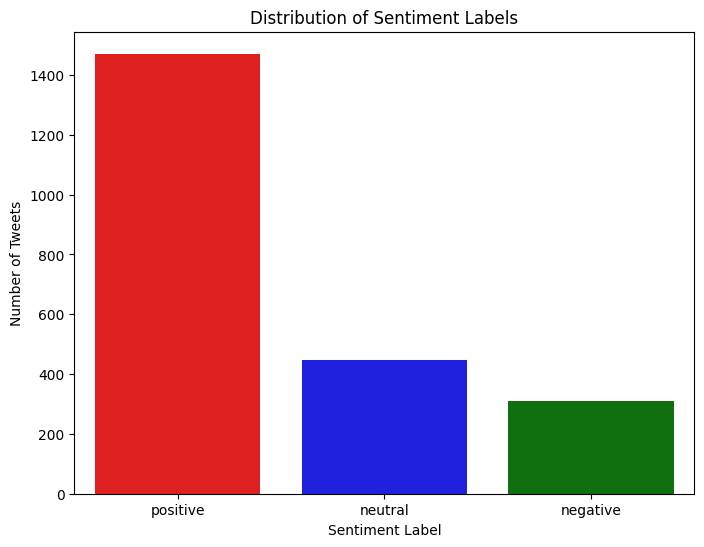

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

jumlah_sampel_per_kelas = df['label'].value_counts()
proporsi_label = df['label'].value_counts(normalize=True)

print(jumlah_sampel_per_kelas)
print("\nProporsi masing-masing label:")
print(proporsi_label)

plt.figure(figsize=(8, 6))
sns.barplot(x=jumlah_sampel_per_kelas.index, y=jumlah_sampel_per_kelas.values, palette=['red', 'blue', 'green'])
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Sentiment Labels')
plt.xticks(rotation=0)
plt.show()


Wordcloud

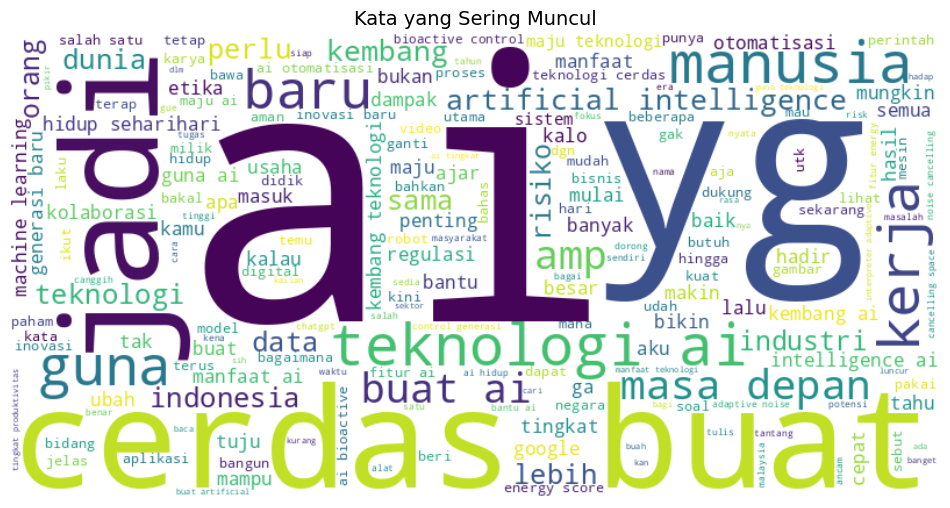

In [63]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = " ".join(df['tweet_clean'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_text)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Kata yang Sering Muncul", fontsize=14)
plt.show()

Save Data

In [64]:
df.to_csv("processed_data.csv", index=False, encoding="utf-8")

In [65]:
df.isnull().sum()

,0
full_text,0
tweet_clean,0
english_text,0
label,0


Data 1

In [ ]:
df = pd.read_csv("final-preprocessing.csv")

X = df['tweet_clean']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

Data 2

In [66]:
df2 = pd.read_csv("processed_data.csv")

X2 = df['tweet_clean']
y2 = df['label']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.1, random_state=42)

# Tanpa Feature Selection

In [ ]:
tfidf_param_grid = {
    'tfidf__max_features': [1000, 2000, 3000, 4000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_df': [0.5, 0.75, 0.85, 0.9],
    'tfidf__min_df': [1, 2, 3, 4, 5]
}

nb_param_grid = {
    'nb__alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]
}

pipeline = ImbPipeline([
    ('tfidf', TfidfVectorizer()),
    ('smote', SMOTE(random_state=42)), #
    ('nb', MultinomialNB())
])

param_grid = {**tfidf_param_grid, **nb_param_grid}

grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Parameter terbaik:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Parameter terbaik:
{'nb__alpha': 0.01, 'tfidf__max_df': 0.5, 'tfidf__max_features': 3000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)}
Accuracy: 0.68
Classification Report:
               precision    recall  f1-score   support

    negative       0.37      0.43      0.40        37
     neutral       0.66      0.45      0.53        47
    positive       0.77      0.82      0.80       141

    accuracy                           0.68       225
   macro avg       0.60      0.57      0.58       225
weighted avg       0.68      0.68      0.68       225



In [68]:
tfidf_param_grid = {
    'tfidf__max_features': [1000, 2000, 3000, 4000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_df': [0.5, 0.75, 0.85, 0.9],
    'tfidf__min_df': [1, 2, 3, 4, 5]
}

nb_param_grid = {
    'nb__alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]
}

pipeline = ImbPipeline([
    ('tfidf', TfidfVectorizer()),
    ('smote', SMOTE(random_state=42)),
    ('nb', MultinomialNB())
])

param_grid = {**tfidf_param_grid, **nb_param_grid}

grid_search2 = GridSearchCV(pipeline, param_grid, cv=5)
grid_search2.fit(X_train2, y_train2)

print("Parameter terbaik:")
print(grid_search2.best_params_)

best_model2 = grid_search2.best_estimator_
y_pred2 = best_model2.predict(X_test2)
print("Accuracy:", accuracy_score(y_test2, y_pred2))
print("Classification Report:\n", classification_report(y_test2, y_pred2))

Parameter terbaik:
{'nb__alpha': 0.01, 'tfidf__max_df': 0.85, 'tfidf__max_features': 5000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Accuracy: 0.672645739910314
Classification Report:
               precision    recall  f1-score   support

    negative       0.39      0.29      0.33        31
     neutral       0.46      0.28      0.35        43
    positive       0.74      0.87      0.80       149

    accuracy                           0.67       223
   macro avg       0.53      0.48      0.49       223
weighted avg       0.64      0.67      0.65       223



# Modelling + Chi Square

In [ ]:
tfidf_param_grid = {
    'tfidf__max_features': [1000, 2000, 3000, 4000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_df': [0.5, 0.75, 0.85, 0.9],
    'tfidf__min_df': [1, 2, 3, 4, 5]
}

chi_param_grid = {
    'chi2__k': [500, 1000, 2000, 'all']
}

nb_param_grid = {
    'nb__alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]
}

pipeline = ImbPipeline([
    ('tfidf', TfidfVectorizer()),
    ('chi2', SelectKBest(chi2)),
    ('smote', SMOTE(random_state=42)),
    ('nb', MultinomialNB())
])

param_grid = {**tfidf_param_grid, **chi_param_grid, **nb_param_grid}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Parameter terbaik:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 4800 candidates, totalling 24000 fits
Parameter terbaik:
{'chi2__k': 1000, 'nb__alpha': 0.01, 'tfidf__max_df': 0.85, 'tfidf__max_features': 2000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
Accuracy: 0.6844444444444444
Classification Report:
               precision    recall  f1-score   support

    negative       0.38      0.49      0.43        37
     neutral       0.62      0.55      0.58        47
    positive       0.81      0.78      0.79       141

    accuracy                           0.68       225
   macro avg       0.60      0.61      0.60       225
weighted avg       0.70      0.68      0.69       225



In [69]:
tfidf_param_grid = {
    'tfidf__max_features': [1000, 2000, 3000, 4000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_df': [0.5, 0.75, 0.85, 0.9],
    'tfidf__min_df': [1, 2, 3, 4, 5]
}

chi_param_grid = {
    'chi2__k': [500, 1000, 2000, 'all']
}

nb_param_grid = {
    'nb__alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]
}

pipeline = ImbPipeline([
    ('tfidf', TfidfVectorizer()),
    ('chi2', SelectKBest(chi2)),
    ('smote', SMOTE(random_state=42)),
    ('nb', MultinomialNB())
])

param_grid = {**tfidf_param_grid, **chi_param_grid, **nb_param_grid}

grid_search2 = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search2.fit(X_train2, y_train2)

print("Parameter terbaik:")
print(grid_search2.best_params_)

best_model2 = grid_search2.best_estimator_
y_pred2 = best_model2.predict(X_test2)
print("Accuracy:", accuracy_score(y_test2, y_pred2))
print("Classification Report:\n", classification_report(y_test2, y_pred2))


Fitting 5 folds for each of 4800 candidates, totalling 24000 fits
Parameter terbaik:
{'chi2__k': 'all', 'nb__alpha': 0.01, 'tfidf__max_df': 0.85, 'tfidf__max_features': 5000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Accuracy: 0.672645739910314
Classification Report:
               precision    recall  f1-score   support

    negative       0.39      0.29      0.33        31
     neutral       0.46      0.28      0.35        43
    positive       0.74      0.87      0.80       149

    accuracy                           0.67       223
   macro avg       0.53      0.48      0.49       223
weighted avg       0.64      0.67      0.65       223



# Class Prior (No Smote)

In [ ]:
tfidf_param_grid = {
    'tfidf__max_features': [1000, 2000, 3000, 4000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_df': [0.5, 0.75, 0.85, 0.9],
    'tfidf__min_df': [1, 2, 3, 4, 5]
}

nb_param_grid = {
    'nb__alpha' : [0.01, 0.1, 0.5, 1.0, 2.0, 5.0],
    'nb__class_prior': [
        [0.6, 0.3, 0.1],
        [0.5, 0.3, 0.2],
        [0.4, 0.4, 0.2],
        [0.3, 0.4, 0.3]
        ]
}

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

param_grid = {**tfidf_param_grid, **nb_param_grid}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Parameter terbaik:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 4800 candidates, totalling 24000 fits
Parameter terbaik:
{'nb__alpha': 1.0, 'nb__class_prior': [0.3, 0.4, 0.3], 'tfidf__max_df': 0.5, 'tfidf__max_features': 5000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
Accuracy: 0.72
Classification Report:
               precision    recall  f1-score   support

    negative       0.68      0.35      0.46        37
     neutral       0.53      0.66      0.59        47
    positive       0.80      0.84      0.82       141

    accuracy                           0.72       225
   macro avg       0.67      0.62      0.62       225
weighted avg       0.72      0.72      0.71       225



In [70]:
tfidf_param_grid = {
    'tfidf__max_features': [1000, 2000, 3000, 4000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_df': [0.5, 0.75, 0.85, 0.9],
    'tfidf__min_df': [1, 2, 3, 4, 5]
}

nb_param_grid = {
    'nb__alpha' : [0.01, 0.1, 0.5, 1.0, 2.0, 5.0],
    'nb__class_prior': [
        [0.6, 0.3, 0.1],
        [0.5, 0.3, 0.2],
        [0.4, 0.4, 0.2],
        [0.3, 0.4, 0.3]
        ]
}

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

param_grid = {**tfidf_param_grid, **nb_param_grid}
grid_search2 = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search2.fit(X_train2, y_train2)

print("Parameter terbaik:")
print(grid_search2.best_params_)

best_model2 = grid_search2.best_estimator_
y_pred2 = best_model2.predict(X_test2)

print("Accuracy:", accuracy_score(y_test2, y_pred2))
print("Classification Report:\n", classification_report(y_test2, y_pred2))


Fitting 5 folds for each of 4800 candidates, totalling 24000 fits
Parameter terbaik:
{'nb__alpha': 1.0, 'nb__class_prior': [0.3, 0.4, 0.3], 'tfidf__max_df': 0.5, 'tfidf__max_features': 4000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Accuracy: 0.695067264573991
Classification Report:
               precision    recall  f1-score   support

    negative       0.62      0.16      0.26        31
     neutral       0.48      0.49      0.48        43
    positive       0.75      0.87      0.81       149

    accuracy                           0.70       223
   macro avg       0.62      0.51      0.52       223
weighted avg       0.68      0.70      0.67       223



# Class Prior + Chi

In [ ]:
tfidf_param_grid = {
    'tfidf__max_features': [1000, 2000, 3000, 4000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_df': [0.5, 0.75, 0.85, 0.9],
    'tfidf__min_df': [1, 2, 3, 4, 5]
}

chi_param_grid = {
    'chi2__k': [500, 1000, 2000, 'all']
}

nb_param_grid = {
    'nb__alpha' : [0.01, 0.1, 0.5, 1.0, 2.0, 5.0],
    'nb__class_prior': [
        [0.6, 0.3, 0.1],
        [0.5, 0.3, 0.2],
        [0.4, 0.4, 0.2],
        [0.3, 0.4, 0.3]
        ]
}

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('chi2', SelectKBest(chi2)),
    ('nb', MultinomialNB())
])

param_grid = {**tfidf_param_grid, **chi_param_grid, **nb_param_grid}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Parameter terbaik:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 19200 candidates, totalling 96000 fits
Parameter terbaik:
{'chi2__k': 'all', 'nb__alpha': 1.0, 'nb__class_prior': [0.3, 0.4, 0.3], 'tfidf__max_df': 0.5, 'tfidf__max_features': 5000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
Accuracy: 0.7333333333333333
Classification Report:
               precision    recall  f1-score   support

    negative       0.75      0.41      0.53        37
     neutral       0.53      0.66      0.59        47
    positive       0.81      0.84      0.83       141

    accuracy                           0.73       225
   macro avg       0.70      0.64      0.65       225
weighted avg       0.74      0.73      0.73       225



In [72]:
tfidf_param_grid = {
    'tfidf__max_features': [1000, 2000, 3000, 4000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_df': [0.5, 0.75, 0.85, 0.9],
    'tfidf__min_df': [1, 2, 3, 4, 5]
}

chi_param_grid = {
    'chi2__k': [500, 1000, 2000, 'all']
}

nb_param_grid = {
    'nb__alpha' : [0.01, 0.1, 0.5, 1.0, 2.0, 5.0],
    'nb__class_prior': [
        [0.6, 0.3, 0.1],
        [0.5, 0.3, 0.2],
        [0.4, 0.4, 0.2],
        [0.3, 0.4, 0.3]
        ]
}

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('chi2', SelectKBest(chi2)),
    ('nb', MultinomialNB())
])

param_grid = {**tfidf_param_grid, **chi_param_grid, **nb_param_grid}
grid_search2 = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search2.fit(X_train2, y_train2)

print("Parameter terbaik:")
print(grid_search2.best_params_)

best_model2 = grid_search2.best_estimator_
y_pred2 = best_model2.predict(X_test2)

print("Accuracy:", accuracy_score(y_test2, y_pred2))
print("Classification Report:\n", classification_report(y_test2, y_pred2))


Fitting 5 folds for each of 19200 candidates, totalling 96000 fits
Parameter terbaik:
{'chi2__k': 'all', 'nb__alpha': 1.0, 'nb__class_prior': [0.3, 0.4, 0.3], 'tfidf__max_df': 0.5, 'tfidf__max_features': 4000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Accuracy: 0.695067264573991
Classification Report:
               precision    recall  f1-score   support

    negative       0.62      0.16      0.26        31
     neutral       0.48      0.49      0.48        43
    positive       0.75      0.87      0.81       149

    accuracy                           0.70       223
   macro avg       0.62      0.51      0.52       223
weighted avg       0.68      0.70      0.67       223



In [ ]:
import joblib

joblib.dump(grid_search.best_estimator_, "best_model.pkl")
print("Model terbaik telah disimpan sebagai 'best_model.pkl'")

Model terbaik telah disimpan sebagai 'best_model.pkl'


In [ ]:
from google.colab import files
files.download('best_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>